In [1]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from pymystem3 import Mystem
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder
import numpy as np
from sklearn.metrics import roc_auc_score
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

import nltk
nltk.download('stopwords')

from nltk.corpus import stopwords
_stopwords = stopwords.words('russian')

objects = pd.read_csv("df_merge_labelled.csv")
objects.drop(columns='comment', inplace=True)
objects = objects[objects.connectedness != 0]

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/eu2233-16/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
def clean(data, cols_drop, pattern, replacement, lemmatize=True):
    
    if cols_drop != None:
        data = data.drop(columns=cols_drop)
    data = data.fillna('')
    data['text'] = data['name'] + " " + data['author'] + " " + data['technologies']
    data['text'] = data['text'].astype('str')
    data['text'] = data['text'].apply(lambda x: x.lower())
    data['text'] = data.text.str.replace(pattern, replacement)
    if lemmatize:
        m = Mystem()
        data['text'] = data.text.apply(lambda x: ''.join(m.lemmatize(x)).rstrip())
    
    return data

In [3]:
objects_cleaned = clean(data=objects, cols_drop=['regNumber', 'invNumber', 'gikNumber', 'type', 'nativeId',
                                                 'description', 'image'],
                        pattern='[\d+\\.\\,\\!\\?\\-\"\'\\:\\;\\`\\)\\(\\{\\}\\[\\]x+v+i+\\«\\»\\—\\/\\\\\n]', replacement='')

/tmp/ipykernel_758916/3149391528.py:9: FutureWarning: The default value of regex will change from True to False in a future version.
  data['text'] = data.text.str.replace(pattern, replacement)


In [4]:
def vectorize(data, _type, sw=None):
    
    if _type == 'count':
        vectorizer = CountVectorizer(stop_words=sw)
        X = vectorizer.fit_transform(data['text'])
    if _type == 'tfidf':
        vectorizer = TfidfVectorizer(stop_words=sw)
        X = vectorizer.fit_transform(data['text'])
        
    return X, vectorizer.get_feature_names_out()

In [5]:
X, features = vectorize(data=objects_cleaned, _type='count', sw=_stopwords)

In [6]:
X_train, X_test, y_train, y_test = train_test_split(
    X, objects_cleaned['connectedness'], test_size=0.2,
    stratify=objects_cleaned['connectedness'], random_state=123456)

In [7]:
lr_object = LogisticRegression(multi_class='multinomial', max_iter=5000)
lr_object.fit(X_train, y_train)

LogisticRegression(max_iter=5000, multi_class='multinomial')

In [8]:
pd.Series(lr_object.coef_[0], index=features).sort_values(ascending=False).head(7)

махаев        1.504419
медь          0.777659
архитектор    0.731509
петербург     0.715923
гаврилович    0.658178
трускот       0.644665
мастер        0.591607
dtype: float64

In [9]:
pd.Series(lr_object.coef_[1], index=features).sort_values(ascending=False).head(7)

автор       1.717482
рис         1.319011
резец       1.136687
художник    1.129744
акварель    0.824552
серия       0.776312
резцовый    0.671805
dtype: float64

In [10]:
pd.Series(lr_object.coef_[2], index=features).sort_values(ascending=False).head(7)

художник          0.825368
год               0.822519
фотогравюра       0.786551
ан                0.773681
гравировальный    0.767894
гравер            0.767023
леспинас          0.676856
dtype: float64

In [11]:
pd.Series(lr_object.coef_[3], index=features).sort_values(ascending=False).head(7)

печать         1.895087
репродукция    1.388824
открытка       0.826122
альбом         0.597720
иллюстрация    0.558690
москва         0.537046
вырезка        0.514293
dtype: float64

In [12]:
pd.Series(lr_object.coef_[4], index=features).sort_values(ascending=False).head(7)

фотограф       0.808110
изображение    0.654168
слой           0.590436
несущий        0.590436
фотопечать     0.575028
негатив        0.554645
стеклянный     0.501053
dtype: float64

In [13]:
def calculate_average_roc_auc(y_true, y_score_matrix, average='macro'):
    onehotencoder = OneHotEncoder()
    y_true_martix = onehotencoder.fit_transform(np.array(y_true).reshape((-1, 1))).toarray()
    roc_auc = roc_auc_score(y_true = y_true_martix, y_score = y_score_matrix, average=average)
    return roc_auc

In [14]:
calculate_average_roc_auc(
    y_true=y_train, 
    y_score_matrix=lr_object.predict_proba(X_train))

0.9999787552509787

In [15]:
calculate_average_roc_auc(
    y_true=y_test, 
    y_score_matrix=lr_object.predict_proba(X_test))

0.9848879770806784

In [16]:
roc_aucs_train = calculate_average_roc_auc(
    y_true=y_train, 
    y_score_matrix=lr_object.predict_proba(X_train),
    average=None)

roc_aucs_test = calculate_average_roc_auc(
    y_true=y_test, 
    y_score_matrix=lr_object.predict_proba(X_test),
    average=None)

In [17]:
results = pd.DataFrame({'ROC_AUC_test': roc_aucs_test, 
                        'ROC_AUC_train': roc_aucs_train,
                        'class': np.arange(1, 6)})
results['ROC_AUC_test'] = round(results['ROC_AUC_test']*100, 4)
results['ROC_AUC_train'] = round(results['ROC_AUC_train']*100, 4)
results.sort_values('ROC_AUC_test', ascending = False)

,ROC_AUC_test,ROC_AUC_train,class
4,99.7180,100.0000,5
3,98.9784,100.0000,4
2,98.6480,100.0000,3
1,97.8094,99.9964,2
0,97.2902,99.9929,1


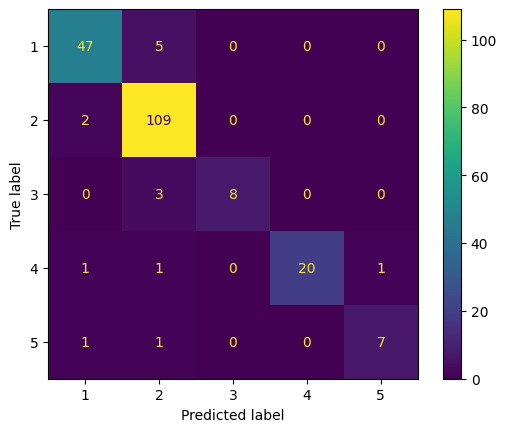

In [18]:
ConfusionMatrixDisplay.from_predictions(y_true=y_test, y_pred=lr_object.predict(X_test))
plt.show()

In [19]:
print(classification_report(y_test, lr_object.predict(X_test)))

              precision    recall  f1-score   support

           1       0.92      0.90      0.91        52
           2       0.92      0.98      0.95       111
           3       1.00      0.73      0.84        11
           4       1.00      0.87      0.93        23
           5       0.88      0.78      0.82         9

    accuracy                           0.93       206
   macro avg       0.94      0.85      0.89       206
weighted avg       0.93      0.93      0.93       206



In [20]:
print(classification_report(y_train, lr_object.predict(X_train)))

              precision    recall  f1-score   support

           1       1.00      1.00      1.00       207
           2       1.00      1.00      1.00       443
           3       1.00      1.00      1.00        45
           4       1.00      1.00      1.00        93
           5       1.00      1.00      1.00        35

    accuracy                           1.00       823
   macro avg       1.00      1.00      1.00       823
weighted avg       1.00      1.00      1.00       823

